In [31]:
import subprocess
from multiprocessing import Pool,cpu_count
import os
from itertools import product,repeat
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import spline,CubicSpline
from scipy.ndimage.filters import gaussian_filter1d
from scipy import stats
import fileinput as fi
from peaks import *
import seaborn as sns
import pickle as pkl

%run averaging.ipynb
%run optimize_slope.ipynb

ncores=cpu_count()

ERROR:root:File `'averaging.ipynb.py'` not found.
ERROR:root:File `'optimize_slope.ipynb.py'` not found.


In [13]:
area_er = 2*(3.9+0.1+0.1*0.1+3.9*0.1)
vol_er = (3.9*0.1*0.1)
vol_cyt = (4.0*0.5*0.5-vol_er)
vol_tot = vol_cyt + vol_er
N_avo=6.0221409e23

res_loc="/home/kabir/Project/tripartiteSynapse/results/ppf/"
result={}
#fname=fnames[10]
sims=["clamped/R150control","clamped/R150ER2x","clamped/R300ER2x","clamped/R150ER3x","clamped/R300ER3x"]#"ryr_old","stores_blocked",
fnames=['RSI20V60.mdl','RSI20V80.mdl','RSI20V100.mdl','RSI20V120.mdl']
for sim_type in sims:
    result[sim_type]={}
    for fname in fnames:
        loc=res_loc+sim_type+'/'+fname.replace(".mdl","")+'/'+'azCaConc.dat'
        loc_rep=res_loc+sim_type+'/'+fname.replace(".mdl","")+'/'+'CaConc'
        os.rename(loc,loc_rep)

## Loading results data

In [46]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/ppf/"
result={}
#fname=fnames[10]
sims=["archive/clamped/R150control","archive/clamped/R150ER2x","archive/clamped/R300ER2x","archive/clamped/R150ER3x","archive/clamped/R300ER3x"]
#["clamped/R150control","clamped/R150ER2x","clamped/R300ER2x","clamped/R150ER3x","clamped/R300ER3x"],\
      #"R150control","R300ER2x" ,"R300ER3x","R150ER3x" ,"R150ER2x"]#"ryr_old","stores_blocked",
#sims=["12may2020/R150control","12may2020/R150ER2x","12may2020/R300ER2x","12may2020/R150ER3x","12may2020/R300ER3x"]
fnames=['RSI20V'+ str(v) +'.mdl' for v in range(60,130,20)]
for sim_type in sims:
    result[sim_type]={}
    for fname in fnames:
        loc=res_loc+sim_type+'/'+fname.replace(".mdl","")+'/'+'result'
        if os.path.isfile(loc):
            with open(loc,'r') as f:
                l=f.readlines()
                result[sim_type][fname]=[float(a) for a in l[-1].replace('\n','').split('\t')]
        else:
            result[sim_type][fname]=[np.nan]*5
            print("Path does not exist:",loc)
            
better_sim_names = {
    "ryr_old":"old model",
    "stores_blocked":"stores blocked",
    "archive/clamped/R150control":"Physiological Control", 
    "archive/clamped/R150ER2x":"Normal RyR, Double ER Calcium",
    "archive/clamped/R150ER3x":"Normal RyR, Triple ER Calcium",
    "archive/clamped/R300ER3x":"Double RyR, Triple ER Calcium",
    "archive/clamped/R300ER2x":"Double RyR, Double ER Calcium",
    "12may2020/R150control":"Physiological Control", 
    "12may2020/R150ER2x":"Normal RyR, Double ER Calcium",
    "12may2020/R150ER3x":"Normal RyR, Triple ER Calcium",
    "12may2020/R300ER3x":"Double RyR, Triple ER Calcium",
    "12may2020/R300ER2x":"Double RyR, Double ER Calcium"
    
}

fnames
VDCC_range=[int(a.split('V')[1].split('.')[0]) for a in fnames]
print(VDCC_range)

[60, 80, 100, 120]


In [14]:
rec="/home/kabir/Project/tripartiteSynapse/results/rec.pkl"
with open(rec,'rb') as f:
    no_of_seeds=pkl.load(f)

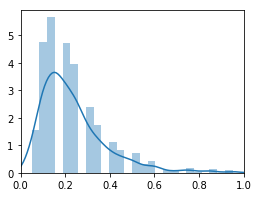

In [15]:
loc="/home/kabir/Project/tripartiteSynapse/murthy/Pr distribution-Murthy1997.dat"

murthy_dist=np.loadtxt(loc)
fig,ax=plt.subplots(1,1,figsize=(4,3))



y=[]
for i in range(20):
    y+=[murthy_dist[i,0]]*int(murthy_dist[i,1])
y=np.array(y)
ax.set_xlim((0,1))
ax=sns.distplot(y)

In [28]:
np.dot(murthy_dist[:,0],murthy_dist[:,1].T)/np.sum(murthy_dist[:,1])

0.23556280587275694

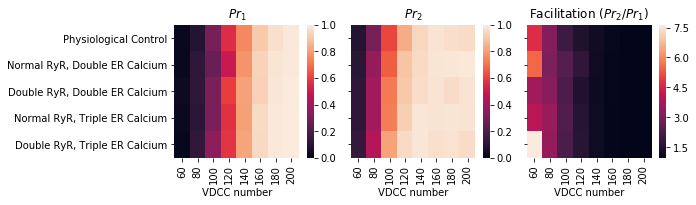

In [23]:
fig,ax=plt.subplots(1,3,figsize=(10,3),sharey=True)
#plt.rc('font',size=13)
#sims=["stores_blocked","R150control","R300ER2x" ,"R300ER3x","R150ER3x" ,"R150ER2x"] #"ryr_old", 
VDCC_range=[int(a.split('V')[1].split('.')[0]) for a in fnames]

cpalette=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]

pr1_data=[[result[sim_type][fname][0] for fname in fnames] for sim_type in sims]
pr2_data=[[result[sim_type][fname][2] for fname in fnames] for sim_type in sims]
ppf_data=[[result[sim_type][fname][2]/result[sim_type][fname][0] for fname in fnames] for sim_type in sims]

y_title_margin=1
ax[0].set_title("$Pr_1$",      y = y_title_margin)
ax[1].set_title("$Pr_2$",      y = y_title_margin)
ax[2].set_title("Facilitation ($Pr_2/Pr_1$)", y = y_title_margin)          

sns.heatmap(pr1_data,vmin=0, vmax=1,xticklabels=VDCC_range,yticklabels=[better_sim_names[simtype] for simtype in sims],ax=ax[0])
sns.heatmap(pr2_data,vmin=0, vmax=1,xticklabels=VDCC_range,yticklabels=[better_sim_names[simtype] for simtype in sims],ax=ax[1])
sns.heatmap(ppf_data,xticklabels=VDCC_range,yticklabels=[better_sim_names[simtype] for simtype in sims],ax=ax[2])

ax[0].set_xlabel("VDCC number")
ax[1].set_xlabel("VDCC number")
ax[2].set_xlabel("VDCC number")          

plt.tight_layout()
plt.subplots_adjust(left=0.27,bottom=0.25)

plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/ppr_heatmap.eps",transparent=True)
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/jpeg/pr_heatmap.jpeg",dpi=300)

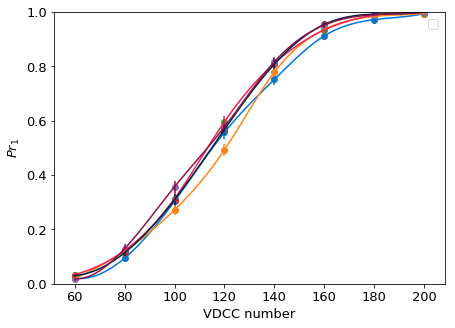

In [41]:
plt.figure(figsize=(7,5))
plt.rc('font',size=13)
#sims=["stores_blocked","R150control","R300ER2x" ,"R300ER3x","R150ER3x" ,"R150ER2x"] #"ryr_old", 
#VDCC_range=[int(a.split('V')[1].split('.')[0]) for a in fnames]

cpalette=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]

def func(x,A,B):
    return np.tanh(A+B*x)

for (sim_type,color) in zip(sims,cpalette):
    ydata=[result[sim_type][fname][0] for fname in fnames]
    yerr=[result[sim_type][fname][1] for fname in fnames]
    #plt.plot(VDCC_range,ydata,marker='o',linestyle='-',color=color)#better_sim_names[sim_type]
    plt.errorbar(VDCC_range,ydata,yerr=yerr,color=color,linestyle='')
    plt.scatter(VDCC_range,ydata)
    
    
    x_val=np.linspace(VDCC_range[0],VDCC_range[-1],100)
    
    #opt=curve_fit(func,VDCC_range,ydata)
    #plt.plot(x_val,func(x_val,*opt[0]),label='tanh')
    
    #p=np.polyfit(VDCC_range,ydata,3)
    #y_val=np.polyval(p,x_val)
    #np.set_printoptions(precision=3)
    #plt.plot(x_val,y_val,color=color[1],label='$Ax^3+Bx^2+Cx+D$\n'+str(p))
    #print(p)
    
    cs=CubicSpline(VDCC_range,ydata)
    x_val=np.linspace(VDCC_range[r],VDCC_range[-1],100)
    y_val=cs(x_val)#func(x_val,*opt[0])#np.polyval(p,x_val)
    plt.plot(x_val,y_val,color=color)

#x_val=np.linspace(VDCC_range[0],VDCC_range[-1],100)
#y_val=np.polyval([-1.205e-06, 4.109e-04, -3.469e-02, 8.770e-01],x_val)
#plt.plot(x_val,y_val,label='old_fit')    
    
plt.legend()
#plt.grid()
#plt.title("Vesicle Release Probability for the first pulse")
plt.xlabel("VDCC number")
plt.ylabel("$Pr_{1}$")
plt.ylim(0,1)
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/VDCCrangeP1_190320.eps",transparent=True)
#lt.savefig("/home/kabir/Project/tripartiteSynapse/plots/jpeg/VDCCrangeP1.jpeg",dpi=300)

###### [-1.205e-06  4.109e-04 -3.469e-02  8.770e-01]

Text(0, 0.5, '$Pr_{2}$')

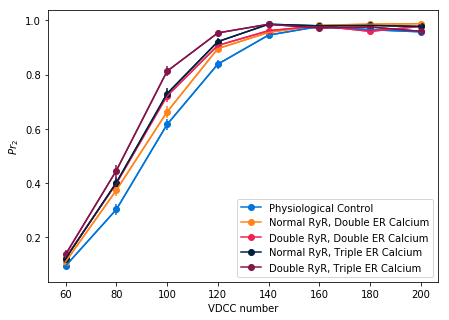

In [24]:
plt.figure(figsize=(7,5))
#plt.rc('font',size=13)

VDCC_range=[int(a.split('V')[1].split('.')[0]) for a in fnames]

cpalette=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]

for (sim_type,color) in zip(sims,cpalette):
    ydata=[result[sim_type][fname][2] for fname in fnames]
    yerr=[result[sim_type][fname][3] for fname in fnames]
    plt.plot(VDCC_range,ydata,label=better_sim_names[sim_type],marker='o',linestyle='-',color=color)
    plt.errorbar(VDCC_range,ydata,yerr=yerr,color=color)
plt.legend()
#plt.title("Vesicle Release Probability for the second pulse")
plt.xlabel("VDCC number")
plt.ylabel("$Pr_{2}$")
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/VDCCrangeP2.eps")
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/jpeg/VDCCrangeP2.jpeg",dpi=300)

Text(0.5, 1.0, 'Paired Pulse facilitation, ER ends clamped')

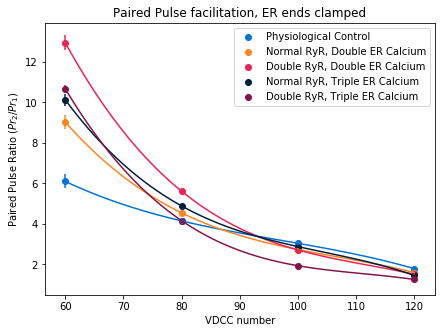

In [47]:
plt.figure(figsize=(7,5))
plt.rc('font',size=10)

r=0

VDCC_range=[int(a.split('V')[1].split('.')[0]) for a in fnames]

cpalette=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]
#sims=["clamped/R150control"]#,"clamped/R150ER2x","clamped/R300ER2x","clamped/R150ER3x","clamped/R300ER3x"]

def func(x,A,B,C):
    return A*np.exp(B*x)+C

for (sim_type,color) in zip(sims,cpalette):
    ydata=[result[sim_type][fname][2]/result[sim_type][fname][0] for fname in fnames]
    yerr=[np.sqrt((result[sim_type][fname][1]/result[sim_type][fname][0])**2+(result[sim_type][fname][3]/result[sim_type][fname][2])**2) for fname in fnames]
    plt.scatter(VDCC_range[r:],ydata[r:],label=better_sim_names[sim_type],color=color)
    plt.errorbar(VDCC_range[r:],ydata[r:],yerr=yerr[r:],color=color,linestyle='')#,label=better_sim_names[sim_type])
    
    #p=np.polyfit(VDCC_range[r:],ydata,5)
    #opt=curve_fit(func,VDCC_range,ydata,p0=(1,-1,0.1))
    cs=CubicSpline(VDCC_range,ydata)
    x_val=np.linspace(VDCC_range[r],VDCC_range[-1],100)
    y_val=cs(x_val)#func(x_val,*opt[0])#np.polyval(p,x_val)
    plt.plot(x_val,y_val,color=color)
    
    
    new_sim_type=sim_type.replace('clamped/','')
    
    #ydata=[result[new_sim_type][fname][2]/result[new_sim_type][fname][0] for fname in fnames]
    #yerr=[np.sqrt((result[new_sim_type][fname][1]/result[new_sim_type][fname][0])**2+(result[sim_type][fname][3]/result[sim_type][fname][2])**2) for fname in fnames]
    #plt.plot(VDCC_range[r:],ydata[r:],label=new_sim_type,marker='o',linestyle='-',color=color)
    #plt.errorbar(VDCC_range[r:],ydata[r:],yerr=yerr[r:],color=color)
    
plt.legend()
plt.xlabel("VDCC number")
plt.ylabel("Paired Pulse Ratio ($Pr_{2}/Pr_{1}$)")
plt.title("Paired Pulse facilitation, ER ends clamped")#, ER 100nm")
#plt.xlim((120,200))
#plt.ylim((0.5,3))
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/VDCCrangePPR_clamped_ER100nm_190320_zoom.eps",transparent=True)
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/jpeg/VDCCrangePPR_clamped.jpeg",dpi=300)#

In [34]:
plt.figure(figsize=(7,5))
#print(list(range(40,170,10)))
sims=["clamped/R150control","clamped/R150ER2x","clamped/R300ER2x","clamped/R150ER3x","clamped/R300ER3x"]
for sim_type in sims:
    plt.plot([result[sim_type][fname][0] for fname in fnames],[result[sim_type][fname][2]/result[sim_type][fname][0] for fname in fnames],label=sim_type,marker='o',linestyle='-')
plt.legend()
#plt.ylim((0,3))
#plt.xlim((0,0.4))
plt.xlabel("P1")
plt.ylabel("PPR")
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/VDCCrangePPR_P1.pdf")

KeyError: 'clamped/R150control'

<Figure size 504x360 with 0 Axes>

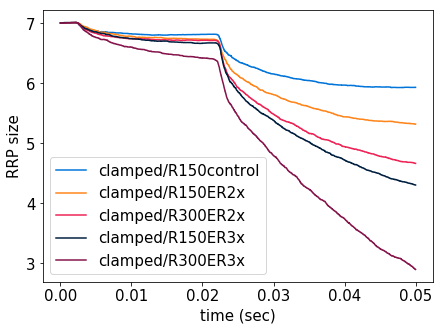

In [11]:
for v in [100]:
    res_loc="/home/kabir/Project/tripartiteSynapse/results/ppf/"
    data={}
    fnames=["RSI20V"+str(v)]
    for (name,sim_type) in product(fnames,sims):
        #name="RSI20V90"
        loc=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'rrp.dat'
        data[sim_type+name]=np.loadtxt(loc)



    plt.figure(figsize=(7,5))
    plt.rc('font',size=15)
    for (name,(i,sim_type)) in product(fnames,enumerate(sims)):
        xdata=data[sim_type+name].T[0]
        ydata=data[sim_type+name].T[1]
        plt.plot(xdata,ydata,label=sim_type,color=cpalette[i])
    #plt.title("Readily Releasable Pool (RRP) size for VDCC = "+str(v))
    plt.xlabel("time (sec)")
    plt.ylabel("RRP size")
    #plt.title("Calcium Flux into Cytosol through Ryanodine receptors")
    plt.legend()

    #plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/RRP_VDCC"+str(v)+".eps",transparent=True)
    #plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/jpeg/RRP_VDCC"+str(v)+".jpeg",dpi=300)

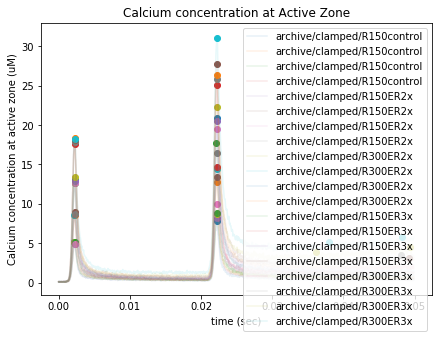

In [118]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/ppf/"
data={}
for sim_type in sims:
    data[sim_type]={}
    for name in fnames:
        loc=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'CaConc'
        data[sim_type][name]=np.loadtxt(loc)
    

plt.figure(figsize=(7,5))
for sim_type in sims:
    for name in fnames:
        xdata=data[sim_type][name].T[0]
        ydata=data[sim_type][name].T[1]
        plt.plot(xdata,ydata,label=sim_type,alpha=0.1)
        p=detect_peaks(data[sim_type][name].T[1],mpd=200,mph=3)
        plt.scatter(xdata[p],ydata[p])

plt.xlabel("time (sec)")
plt.ylabel("Calcium concentration at active zone (uM)")
plt.title("Calcium concentration at Active Zone")
plt.legend()
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/azRSI20V80.eps")
#plt.xlim((0,0.005))
#plt.ylim((8,9))

In [25]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/ppf/"
data={}
for sim_type in sims:
    data[sim_type]={}
    for name in fnames:
        loc=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'CaConc'
        data[sim_type][name]=np.loadtxt(loc)
    

fig,ax=plt.subplots(1,2,figsize=(8,3),sharey=True)

spikes=detect_peaks(data[sim_type][fname].T[1],mpd=200,mph=3)

ca_peak1_data=[[data[sim_type][fname].T[1][detect_peaks(data[sim_type][fname].T[1],mpd=200,mph=3)[0]] for fname in fnames] for sim_type in sims]
ca_peak2_data=[[data[sim_type][fname].T[1][detect_peaks(data[sim_type][fname].T[1],mpd=200,mph=3)[1]] for fname in fnames] for sim_type in sims]

sns.heatmap(ca_peak1_data,vmin=5,vmax=30,xticklabels=VDCC_range,yticklabels=[better_sim_names[simtype] for simtype in sims],ax=ax[0])
sns.heatmap(ca_peak2_data,vmin=5,vmax=30,xticklabels=VDCC_range,yticklabels=[better_sim_names[simtype] for simtype in sims],ax=ax[1])

ax[0].set_title('First Ca2+ peak\n at active zone ($\mu M$)')
ax[1].set_title('Second Ca2+ peak\n at active zone ($\mu M$)')

ax[0].set_xlabel("VDCC number")
ax[1].set_xlabel("VDCC number")

plt.subplots_adjust(hspace=0.2)

plt.tight_layout()
plt.subplots_adjust(left=0.3,bottom=0.2)
plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/ppf_ca_peaks_heat.eps")

OSError: /home/kabir/Project/tripartiteSynapse/results/ppf/12may2020/R150control/RSI20V60/CaConc not found.

In [93]:
data['archive/clamped/R150control']['RSI20V100.mdl']

array([[0.000e+00, 1.100e-01, 4.000e-02],
       [5.000e-05, 1.300e-01, 3.000e-02],
       [1.000e-04, 8.000e-02, 2.000e-02],
       ...,
       [4.980e-02, 4.600e-01, 6.000e-02],
       [4.985e-02, 4.600e-01, 6.000e-02],
       [4.990e-02, 4.500e-01, 5.000e-02]])

In [75]:
ca_peak1_data

[[17.58, 17.58, 17.58, 17.58],
 [17.7, 17.7, 17.7, 17.7],
 [18.31, 18.31, 18.31, 18.31],
 [18.11, 18.11, 18.11, 18.11],
 [18.27, 18.27, 18.27, 18.27]]

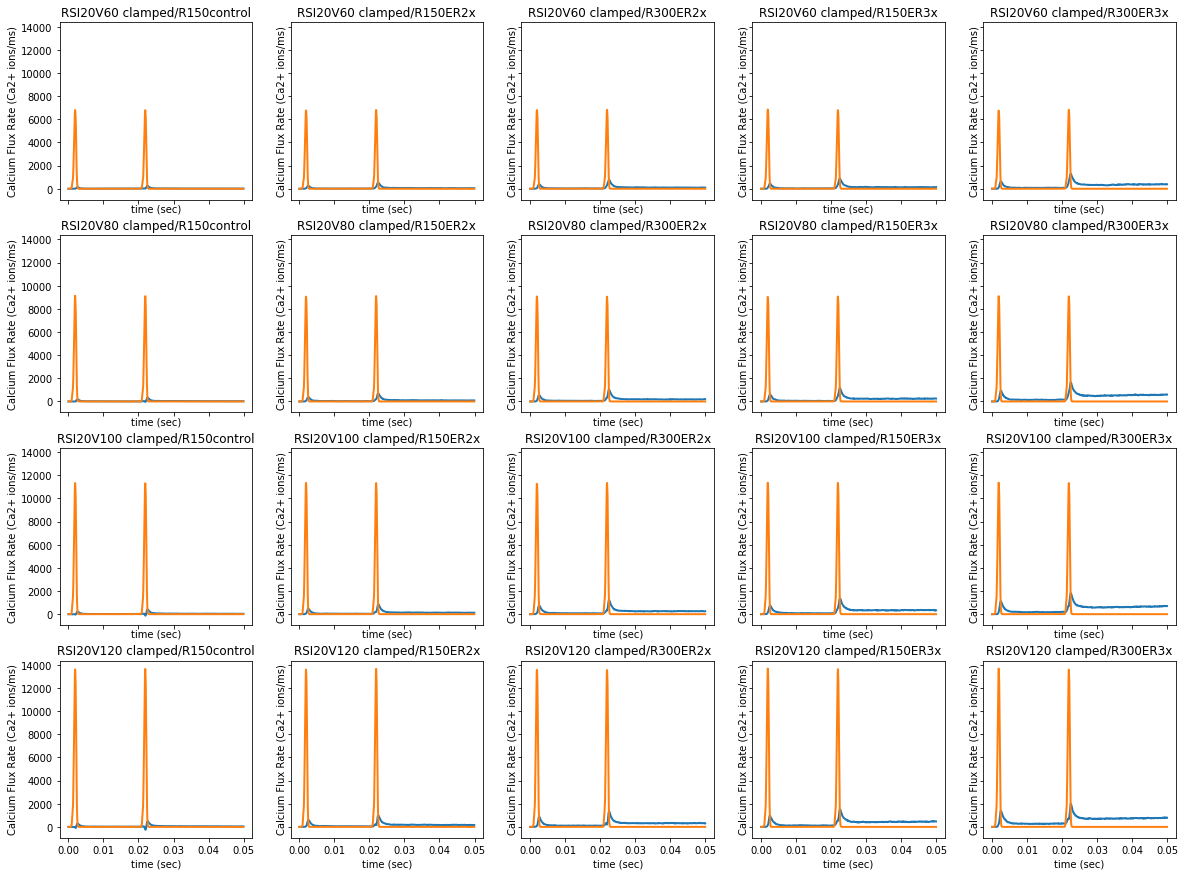

In [61]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/ppf/"
sims=["clamped/R150control","clamped/R150ER2x","clamped/R300ER2x","clamped/R150ER3x","clamped/R300ER3x"]
data={'serca':{},'vdcc':{},'ryr':{}}

for sim_type in sims:
    for key in data.keys():
        data[key][sim_type]={}
    for namemdl in fnames:
        name=namemdl.replace(".mdl","")
        loc_ryr_flux=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'ryrCaFluxRate.dat'
        loc_vdcc_flux=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'vdccCaFluxRate.dat'
        loc_serca_flux=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'sercaCaFlux.dat'
        data['ryr'][sim_type][name]=np.loadtxt(loc_ryr_flux)
        data['vdcc'][sim_type][name]=np.loadtxt(loc_vdcc_flux)
        data['serca'][sim_type][name]=np.loadtxt(loc_serca_flux)
    

fig,ax=plt.subplots(len(fnames),len(sims),figsize=(20,15),sharex=True,sharey=True)
for i,namemdl in enumerate(fnames):
    for j,sim_type in enumerate(sims):
        name=namemdl.replace(".mdl","")
        ax[i,j].set_title(name+" "+sim_type)
        xdata=data['ryr'][sim_type][name].T[0]
        ydata=(data['ryr'][sim_type][name].T[1]-data['ryr'][sim_type][name].T[2])*1e-3
        ax[i,j].plot(xdata,ydata,label=sim_type+" RyR flux",lw="2")

        xdata=data['vdcc'][sim_type][name].T[0]
        ydata=data['vdcc'][sim_type][name].T[1]*1e-3
        ax[i,j].plot(xdata,ydata,label=sim_type+" VDCC flux",lw="2")

        xdata=data['serca'][sim_type][name].T[0]
        ydata=(data['serca'][sim_type][name].T[1]-data['serca'][sim_type][name].T[2])*1e-3
        ydata=(ydata[1:]-ydata[:-1])/(xdata[1]-xdata[0])
        #ax[i,j].plot(xdata[:-1],ydata,label=sim_type+" serca flux",lw="2")
    
        ax[i,j].set_xlabel("time (sec)")
        ax[i,j].set_ylabel("Calcium Flux Rate (Ca2+ ions/ms)")
        
#plt.xlabel("time (sec)")
#ax.ylabel("Calcium Flux Rate (Ca2+ ions/ms)")
#plt.title("Calcium Flux Rate through Ryanodine receptors")
#plt.legend()
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/ryr_fluxRSI20V80.eps")

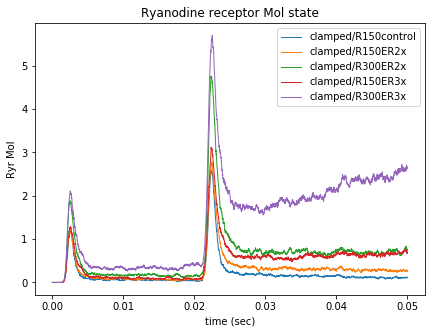

In [42]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/ppf/"
data={}
sims=["clamped/R150control","clamped/R150ER2x","clamped/R300ER2x","clamped/R150ER3x","clamped/R300ER3x"]
for sim_type in sims:
    data[sim_type]={}
    name="RSI20V80"
    loc1=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'ryrMol.dat'

    data[sim_type][name]=np.loadtxt(loc1)
    
    

plt.figure(figsize=(7,5))
for sim_type in sims:
    xdata=data[sim_type][name].T[0]
    #ydata=data[sim_type][name].T[6]+data[sim_type][name].T[7]+data[sim_type][name].T[13]+data[sim_type][name].T[14]
    ydata=np.sum(data[sim_type][name].T[[6,7,13,14]], axis=0)
    plt.plot(xdata,ydata,label=sim_type,lw="1")

plt.xlabel("time (sec)")
plt.ylabel("Ryr Mol")
plt.title("Ryanodine receptor Mol state")
plt.legend()
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/ryr_fluxRSI20V80.eps")

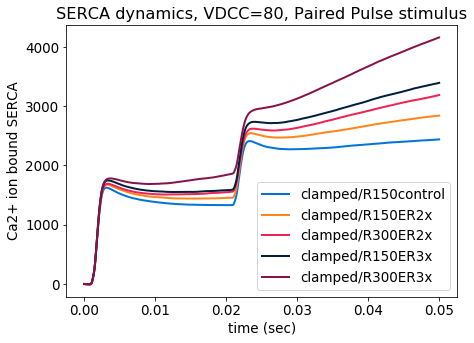

In [21]:
plt.rc('font', size=13.5) 


res_loc="/home/kabir/Project/tripartiteSynapse/results/ppf/"
data_bound={}
bnd_cal={}
cpalette=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]
#sims=["stores_blocked","R150control","R300ER2x" ,"R300ER3x","ryr_old"] #"ryr_old", ,"R150ER3x" ,"R150ER2x"
for sim_type in sims:
    name="RSI20V80"
    loc1=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'serca_mol.dat'
    loc2=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'sercaMol.dat'
    if os.path.isfile(loc1):
        data_bound[sim_type]=np.loadtxt(loc1)
    else:
        data_bound[sim_type]=np.loadtxt(loc2)
    bnd_cal[sim_type]=data_bound[sim_type].T[4]*2+data_bound[sim_type].T[5]+data_bound[sim_type].T[2]+data_bound[sim_type].T[3]*2
    bnd_cal[sim_type]=bnd_cal[sim_type]-bnd_cal[sim_type][0]

plt.figure(figsize=(7,5))
for i,sim_type in enumerate(sims):
    xdata=data_bound[sim_type].T[0]
    ydata=bnd_cal[sim_type]
    plt.plot(xdata,ydata,label=sim_type,lw="2",color=cpalette[i])
plt.xlabel("time (sec)")
plt.ylabel("Ca2+ ion bound SERCA")
plt.title("SERCA dynamics, VDCC=80, Paired Pulse stimulus")
#plt.title("Calcium Flux into Cytosol through Ryanodine receptors")
plt.legend(loc='lower right')

plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/serca_boundRSI20V80.eps")

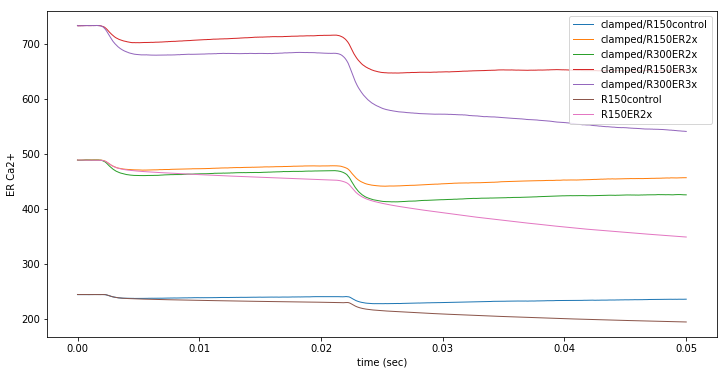

In [9]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/ppf/"
data_bound={}
bnd_cal={}
for sim_type in sims+[s.replace('clamped/','') for s in sims[:2]]:
    name="RSI20V80"
    loc=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'ca.dat'
    data[sim_type]=np.loadtxt(loc)
 

plt.figure(figsize=(12,6))
for sim_type in sims+[s.replace('clamped/','') for s in sims[:2]]:
    xdata=data[sim_type].T[0]
    ydata=data[sim_type].T[3]/24#/602.3
    plt.plot(xdata,ydata,label=sim_type,lw="1")
plt.xlabel("time (sec)")
plt.ylabel("ER Ca2+")
#plt.title("Calcium Flux into Cytosol through Ryanodine receptors")
plt.legend()
#plt.xlim((0,0.01))
#plt.ylim((0,2))
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/ca_cytRSI20V90.eps")

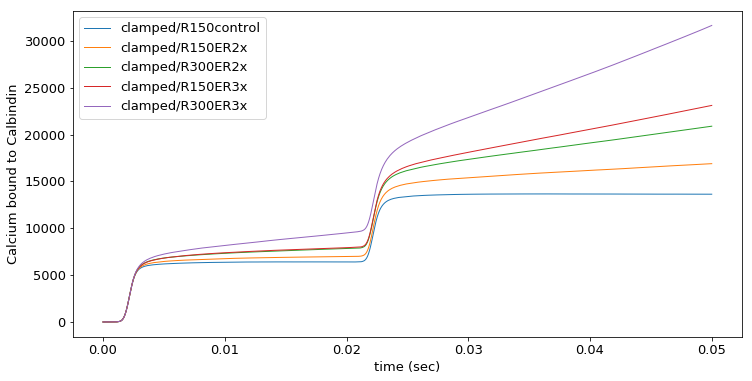

In [57]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/ppf/"
data_bound={}
bnd_cal={}
for sim_type in sims:
    name="RSI20V100"
    loc1=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'calbindin_mol.dat'
    loc2=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'calB.dat'
    if os.path.isfile(loc1):
        data_bound[sim_type]=np.loadtxt(loc1)
    else:
        data_bound[sim_type]=np.loadtxt(loc2)
    bnd_cal[sim_type]=data_bound[sim_type].T[2]+data_bound[sim_type].T[4]+2*(data_bound[sim_type].T[3]+data_bound[sim_type].T[5]+data_bound[sim_type].T[7])+3*(data_bound[sim_type].T[6]+data_bound[sim_type].T[8])+4*data_bound[sim_type].T[9]
    bnd_cal[sim_type]=bnd_cal[sim_type]-bnd_cal[sim_type][0]

plt.figure(figsize=(12,6))
for sim_type in sims:
    xdata=data_bound[sim_type].T[0]
    ydata=bnd_cal[sim_type]
    plt.plot(xdata,ydata,label=sim_type,lw="1")
plt.xlabel("time (sec)")
plt.ylabel("Calcium bound to Calbindin")
#plt.title("Calcium Flux into Cytosol through Ryanodine receptors")
plt.legend()

#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/calb_boundRSI20V80.eps")

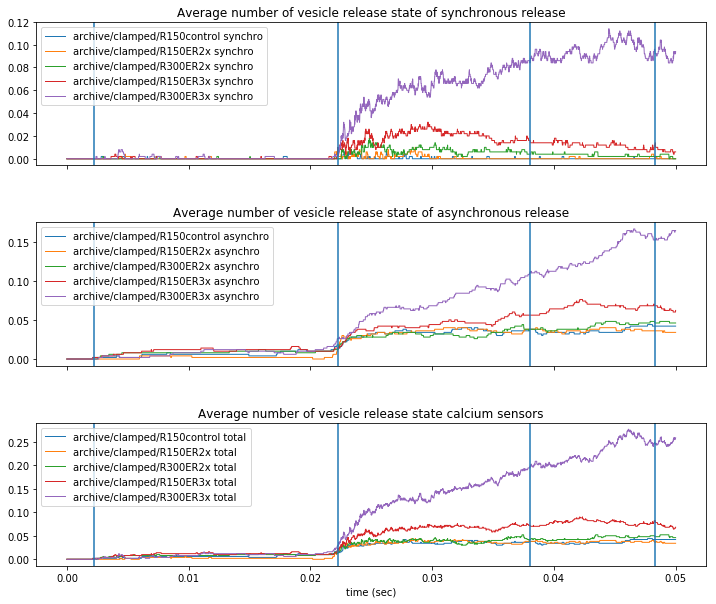

In [138]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/ppf/"
data={}
synchro={}
asynchro={}
for sim_type in sims:
    name="RSI20V60"
    loc=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'az.dat'
    data[sim_type]=np.loadtxt(loc)
    synchro[sim_type]=data[sim_type].T[6]+data[sim_type].T[12]+data[sim_type].T[18]
    asynchro[sim_type]=np.sum(data[sim_type].T[13:19],axis=0)

f, ax = plt.subplots(nrows=3, sharex=True, figsize=(12,10))
f.subplots_adjust(hspace=0.4)
for sim_type in sims:
    xdata=data[sim_type].T[0]
    ax[0].plot(xdata,synchro[sim_type],label=sim_type+" synchro",lw="1")
    ax[1].plot(xdata,asynchro[sim_type],label=sim_type+" asynchro",lw="1")
    ax[2].plot(xdata,asynchro[sim_type]+synchro[sim_type],label=sim_type+" total",lw="1")
titles=["Average number of vesicle release state of synchronous release",
        "Average number of vesicle release state of asynchronous release",
        "Average number of vesicle release state calcium sensors"]
for xis,title in zip(ax,titles):
    #xis.set_ylabel()
    xis.legend()
    xis.set_title(title)
    
for a in ax:
    for s in spikes:
        a.axvline(s/20000)
    
ax[-1].set_xlabel("time (sec)")

plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/releaseRSI20V80.eps")

[2000 1500 1100]


ValueError: Must pass 2-d input

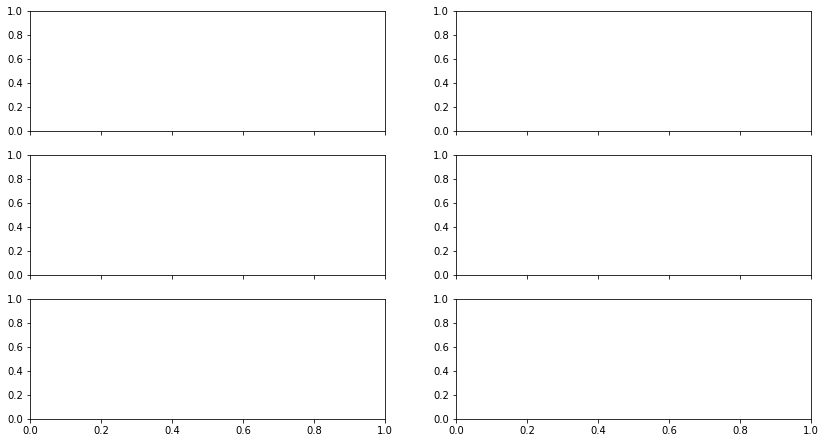

In [140]:
def seed_num(fname):
    vdcc_num=int(fname.split('V')[1].replace('.mdl',''))
    if vdcc_num>=110 and vdcc_num<=160:
        return 1000
    elif vdcc_num>=90 and vdcc_num<=100:
        return 2000
    elif vdcc_num>=70 and vdcc_num<=80:
        return 3000
    elif vdcc_num>=40 and vdcc_num<=60:
        return 5000
    else:
        return 10

    
    
res_loc="/home/kabir/Project/tripartiteSynapse/results/ppf/"
data={}
synchro={}
asynchro={}
total={}
for sim_type in sims:
    synchro[sim_type],asynchro[sim_type],total[sim_type]={},{},{}
    for name in fnames:
        loc=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'az.dat'
        synchro[sim_type][name]=np.array(np.genfromtxt(loc, dtype="|U5").T[0],dtype="float")
        loc=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'az.dat'
        asynchro[sim_type][name]=np.array(np.genfromtxt(loc, dtype="|U5").T[0],dtype="float")
        loc=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'az.dat'
        total[sim_type][name]=np.array(np.genfromtxt(loc, dtype="|U5").T[0],dtype="float")

        
print(np.histogram(synchro[sim_type][fname],bins=spikes/20000)[0])        
synchro_data_bin1 =[[np.histogram(synchro[sim_type][fname],bins=spikes/20000)[0]/seed_num(fname) for name in fnames] for sim_type in sims]
asynchro_data_bin1=[[np.histogram(asynchro[sim_type][fname],bins=spikes/20000)[0]/seed_num(fname) for name in fnames] for sim_type in sims]
total_data_bin1   =[[np.histogram(total[sim_type][fname],bins=spikes/20000)[0]/seed_num(fname) for name in fnames] for sim_type in sims]
synchro_data_bin2 =[[np.histogram(synchro[sim_type][fname],bins=spikes/20000)[1]/seed_num(fname) for name in fnames] for sim_type in sims]
asynchro_data_bin2=[[np.histogram(asynchro[sim_type][fname],bins=spikes/20000)[1]/seed_num(fname) for name in fnames] for sim_type in sims]
total_data_bin2   =[[np.histogram(total[sim_type][fname],bins=spikes/20000)[1]/seed_num(fname) for name in fnames] for sim_type in sims]

f, ax = plt.subplots(nrows=3,ncols=2, sharex=True, figsize=(14,7.5))

sns.heatmap(synchro_data_bin1,vmin=0,vmax=1.2,xticklabels=VDCC_range,yticklabels=[better_sim_names[sim_type] for sim_type in sims],ax=ax[0,0])
sns.heatmap(asynchro_data_bin1,vmin=0,vmax=1.2,xticklabels=VDCC_range,yticklabels=[better_sim_names[sim_type] for sim_type in sims],ax=ax[1,0])    
sns.heatmap(total_data_bin1,vmin=0,vmax=1.2,xticklabels=VDCC_range,yticklabels=[better_sim_names[sim_type] for sim_type in sims],ax=ax[2,0])    

#sns.heatmap(ca_peak1_data,vmin=5,vmax=30,xticklabels=VDCC_range,yticklabels=[better_sim_names[simtype] for simtype in sims],ax=ax[0])
#sns.heatmap(ca_peak2_data,vmin=5,vmax=30,xticklabels=VDCC_range,yticklabels=[better_sim_names[simtype] for simtype in sims],ax=ax[1])


titles=["Vesicle release during 20Hz stimulus (number per spike interval): \nSynchronous release ",
        "Asynchronous release",
        "Total release"]
for t,a in zip(titles,ax):
    a.set_title(t,fontsize=14)
    
ax[-1].set_xlabel("Stimulus number n")

#plt.title("Vesicle Release")

plt.subplots_adjust(hspace=0.2)

plt.tight_layout()
plt.subplots_adjust(left=0.3,bottom=0.09)
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/ppf_release_heat.eps")

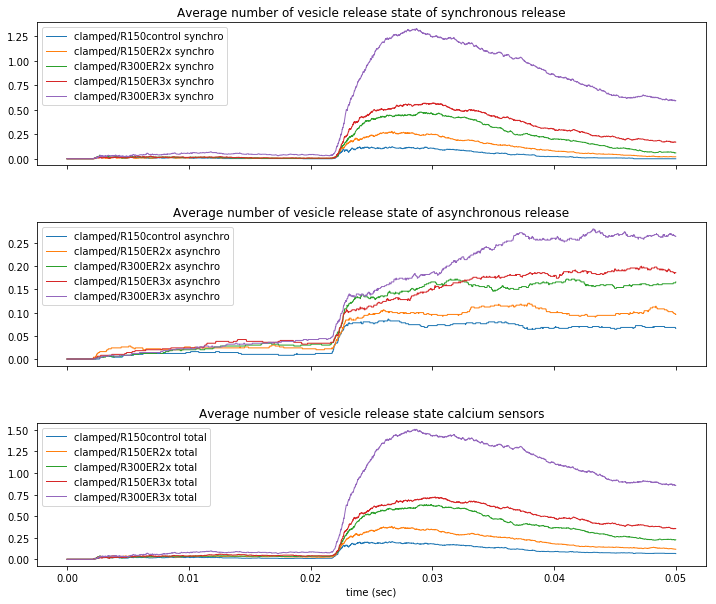

In [10]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/ppf/"
data={}
synchro={}
asynchro={}
for sim_type in sims:
    name="RSI20V100"
    loc=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'az.dat'
    data[sim_type]=np.loadtxt(loc)
    synchro[sim_type]=data[sim_type].T[6]+data[sim_type].T[12]+data[sim_type].T[18]
    asynchro[sim_type]=np.sum(data[sim_type].T[13:19],axis=0)

f, ax = plt.subplots(nrows=3, sharex=True, figsize=(12,10))
f.subplots_adjust(hspace=0.4)
for sim_type in sims:
    xdata=data[sim_type].T[0]
    ax[0].plot(xdata,synchro[sim_type],label=sim_type+" synchro",lw="1")
    ax[1].plot(xdata,asynchro[sim_type],label=sim_type+" asynchro",lw="1")
    ax[2].plot(xdata,asynchro[sim_type]+synchro[sim_type],label=sim_type+" total",lw="1")
titles=["Average number of vesicle release state of synchronous release",
        "Average number of vesicle release state of asynchronous release",
        "Average number of vesicle release state calcium sensors"]
for xis,title in zip(ax,titles):
    #xis.set_ylabel()
    xis.legend()
    xis.set_title(title)
    
ax[-1].set_xlabel("time (sec)")

plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/releaseRSI20V80.eps")

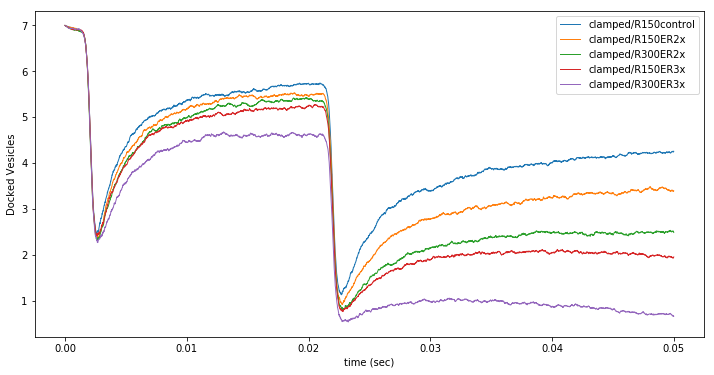

In [12]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/ppf/"
data={}

 

plt.figure(figsize=(12,6))
for sim_type in sims:
    name="RSI20V100"
    loc=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'az.dat'
    data[sim_type]=np.loadtxt(loc)
    xdata=data[sim_type].T[0]
    ydata=data[sim_type].T[1]
    plt.plot(xdata,ydata,label=sim_type,lw="1")
plt.xlabel("time (sec)")
plt.ylabel("Docked Vesicles")
#plt.title("Calcium Flux into Cytosol through Ryanodine receptors")
plt.legend()

#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/ca_cytRSI20V90.eps")